<a href="https://colab.research.google.com/github/JamesExeter/Word-Embeddings-Python/blob/main/4_embedding_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word Embedding

### Aims
* Get familiar with basic Vector Space Model and Word Embedding Models
* Figure out the difference between TF-IDF and Word2Vec
* Explore the application of Word Embedding

### Outline
* Term-document Matrix
* TF-IDF Vector
* Word2Vec

## 1. Acquiring Raw Data & Preprocessing

First, let's obtain all complete works of Shakespeare that we can use to run our word embedding experiments. We'll start the process by downloading some raw text from Project Gutenberg, a repository of hundreds of free ebooks: http://www.gutenberg.org/.

In [2]:
from urllib import request

url = 'http://www.gutenberg.org/files/100/100-0.txt'
response = request.urlopen(url)

# remove single carriage return symbols from each line of text
shakespeare_list = [sent.decode('utf-8').lstrip().replace('\r', '') for sent in response.readlines() if sent != b'\r\n']

# save the text to a local file
with open('shakespeare_sentences.txt', 'w', encoding='utf-8') as f:
    f.writelines(shakespeare_list)

In [3]:
# choose a selection of plays 
title_list = ['Hamlet', 'Romeo&Juliet', 'Twelfth Night', 'Julius Caesar']

# list the URLs for the EBooks
book_url_list = [
    'http://www.gutenberg.org/files/1524/1524-0.txt', 
    'http://www.gutenberg.org/files/1513/1513-0.txt', 
    'http://www.gutenberg.org/files/1526/1526-0.txt', 
    'http://www.gutenberg.org/files/1522/1522-0.txt'
]

book_list = []
for title, url in zip(title_list, book_url_list):
    
    # get data from URL
    response = request.urlopen(url)
    
    # remove single carriage return symbols from each line of text
    sentence_list = [sent.decode('utf-8').lstrip().replace('\r', '') for sent in response.readlines() if sent != b'\r\n']
    
    # join the lines from the file together into a single string
    book = ''.join(sentence_list)
    
    # add the string containing the book's text to the list of books
    book_list.append(book)

In [4]:
# show the first part of each book
for book in book_list:
    print(book[:300])

﻿
Project Gutenberg EBook of Hamlet, by William Shakespeare
This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no
restrictions whatsoever.  You may copy it, give it away or re-use it
under the terms of the Project Gutenberg 
﻿The Project Gutenberg eBook of Romeo and Juliet, by William Shakespeare
This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Projec
﻿	
Project Gutenberg’s Twelfth Night, by William Shakespeare
This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg 
﻿
Project Gutenberg’s Julius Caesar, by William Shakespeare
This eBook is for the use of anyone a

## 2. Term-document Matrix

We are going to build a Term-document Matrix in this part. If you remember from lecture video 3.2, a term document matrix gives us a simple way to construct vector representations of terms and documents.

To complete the matrix, we need to count the number of times that each word occurs in each document. Recall that we have previously used ```FreqDist``` from the ```NLTK``` to count word frequency. However, ```FreqDist``` and other related NLTK classes are not the most convenient tools for obtaining a term-document matrix, as they don't provide a convenient way to look up row and column vectors and perform mathematical operations on them. 

In Python, the best library for working with matrices is ```numpy```, which we have already used. In ```numpy```, matrices (grids of values) are represented by objects of the ```np.array``` class. So how can we get a ```numpy``` array that represents a term-document matrix? We will use the Scikit-learn (```sklearn```) library, which builds on top of numpy to provide tools for machine learning and data science. Sklearn provides the CountVectorizer class to obtain vectors (also ```np.array``` objects with one dimension) from sequences of tokens.

In [12]:
import numpy as np  # for linear algebra
from sklearn.feature_extraction.text import CountVectorizer
from nltk import FreqDist

idx = 3 # choose the book with index 3 -- Julius Caesar


article_list = [book_list[idx]]  # list the articles to vectorize. This time we only vectorize a single book.
vectorizer = CountVectorizer() # initialize a vectorizer to count words
term_doc_spmatrix = vectorizer.fit_transform(article_list) # fit the vectorizer to the given list of documents
vocab = vectorizer.vocabulary_ # returns a dict mapping word to its index of the matrix
features = vectorizer.get_feature_names() # returns all words(features)

print("There are {} words in {}:\n".format(len(features), title_list[idx]))

There are 3304 words in Julius Caesar:



After fitting the vectorizer, the programme returns a sparse matrix $A$, which we assign to ```word_count_sparse```. Each entry of the matrix, $A_{ij}$ represents that word $w_j$ occurs $A_{ij}$ times in document $d_i$. 

A sparse matrix only records the non-zero values in the matrix by their indices, which can save a lot of memory when the matrix is sparse, i.e., when it has mainly zeros. However, it is slightly more complex to work with. So, for our convenience, we can turn the sparse matrix into a standard numpy array by ```toarray()``` (this convenience comes at the cost of taking up more memory).

In [6]:
term_doc_matrix = term_doc_spmatrix.toarray()

print('the dimensions of this word_count array are: {}'.format(term_doc_matrix.shape))

the dimensions of this word_count array are: (1, 3304)


Notice that the ```word_count``` object is a 1x3304 matrix. The single row is because we have only one document at the moment. In this case, rows are documents and columns are terms.

Now we can tell how many times a word occurs in the document by looking up it through the matrix properly.

In [7]:
word_list = [u'battle', u'good', u'fool', u'wit']  # the u before each token indicates a unicode string

word_counts = np.zeros(len(word_list)) # This will be a list of counts for each word. 

for w, word in enumerate(word_list):
    if word in vocab.keys():  
        # If the word is in the vocabulary, add its count to the list.
        word_idx = vocab[word]  # index in the vocabulary
        word_counts[w] = term_doc_matrix[0, word_idx]  # use index zero to refer to the first row/document
    # If the word is not in the vocab, it remains zero.

print("In {}:\n".format(title_list[idx]))
for i, word in enumerate(word_list):
    print("{}: {}\n".format(word, word_counts[i]))

In Julius Caesar:

battle: 9.0

good: 70.0

fool: 1.0

wit: 2.0



TODO: Complete the code below to count the given words in the 4 books stored in ```book_list```. Store the counts in a $4 \times 4$ array called ```term_doc_matrix```. 

In [71]:
word_list = [u'battle', u'good', u'fool', u'wit']

vectorizer = CountVectorizer()
term_doc_spmatrix = vectorizer.fit_transform(book_list)
book_vocab = vectorizer.vocabulary_
term_doc_matrix = term_doc_spmatrix.toarray()

# We will select the columns from the term document matrix that contain counts for words in word_list.
# Unlike the previous cell, instead of storing a single count, we now store word counts for all 4 books. 
term_doc_cols = np.zeros((len(title_list), len(word_list)))  # 4x4 matrix with books as rows and words as cols

### WRITE YOUR CODE HERE
features = vectorizer.get_feature_names() # returns all words(features)
print('the dimensions of this word_count array are: {}'.format(term_doc_matrix.shape))

for idx, book in enumerate(book_list):
  for w, word in enumerate(word_list):
    if word in book_vocab.keys():
      word_idx = book_vocab[word]
      term_doc_cols[idx, w] = term_doc_matrix[idx, word_idx]
  
  print("In {}:\n".format(title_list[idx]))
  for i, word in enumerate(word_list):
    print("{}: {}\n".format(word, term_doc_cols[idx, i]))

['000', '1500', '1513', '1522', '1524', '1526', '18', '1887', '19', '1998', '20', '2001', '2019', '2021', '30', '50', '501', '596', '60', '6221541', '64', '750175', '801', '809', '84116', '90', '99775', '_a', '_above', '_advances', '_advancing', '_alarums', '_alas', '_anon', '_as', '_aside', '_beating', '_beats', '_behind', '_beneath', '_bonos', '_breaking', '_brutus', '_but', '_by', '_casca', '_castiliano', '_catch', '_charges', '_clock', '_cries', '_cucullus', '_descends', '_dies', '_dieu', '_digs', '_diluculo', '_doubt', '_drawing', '_draws', '_drinks', '_enter', '_enters', '_et', '_exeunt', '_exit', '_falls', '_fare', '_farewell', '_flourish', '_for', '_ghost', '_gives', '_goes', '_going', '_grappling', '_hamlet', '_he', '_hey', '_hic', '_his', '_i', '_if', '_juliet', '_king', '_kisses', '_kissing', '_kneeling', '_knock', '_knocking', '_laertes', '_laying', '_leaps', '_loud', '_low', '_lucius', '_lying', '_makes', '_march', '_music', '_my', '_noise', '_nurse', '_o', '_offering', '_

In [37]:
# Pandas is a great library for handling data in matrices and CSV files. 
# We can use it here just to display the selected columns of the term-document matrix.
import pandas as pd  

# Create a Pandas DataFrame object to represent the selected part of the term-document matrix 
# and print it with nice formatting.
term_doc_df = pd.DataFrame(term_doc_cols, columns=word_list, index=title_list)
print(term_doc_df)

               battle   good  fool   wit
Hamlet            0.0  110.0   7.0   6.0
Romeo&Juliet      0.0   85.0   7.0  13.0
Twelfth Night     0.0   80.0  58.0  15.0
Julius Caesar     9.0   70.0   1.0   2.0


TODO: use the complete term-document matrix in ```term_doc_matrix``` to print the term vector for the word 'old'. 
Hint: terms correspond to columns in ```term_doc_matrix```.

In [70]:
###WRITE YOUR OWN CODE HERE
print(len(features))
term_doc_df_all = pd.DataFrame(term_doc_matrix, columns=features, index=title_list)
print(term_doc_df_all['old'])


8541
Hamlet           22
Romeo&Juliet     30
Twelfth Night    14
Julius Caesar    10
Name: old, dtype: int64


TODO: print the document vector for 'Romeo&Juliet' from ```term_doc_matrix```.

In [44]:
# we can find the index of the play in title_list by using where to indicate for which indexes in the array
# a condition is true.
didx = np.where(np.array(title_list) == 'Romeo&Juliet')[0][0]

###WRITE YOUR OWN CODE HERE
print(term_doc_matrix[didx])


[1 1 4 ... 1 0 2]


TODO: Using ```term_doc_cols```, compute the total counts of the words in ```word_list``` across all the books in the dataset. Store the counts in a variable ```word_counts```.

Hint: you can use numpy's sum().

In [53]:
### WRITE YOUR OWN CODE HERE 
word_counts = []
for idx_w in range(len(word_list)):
  word_counts.append(np.sum(term_doc_cols[:,idx_w]))


In [54]:
for i, word in enumerate(word_list):
    print("{}: {}\n".format(word, word_counts[i]))

battle: 9.0

good: 345.0

fool: 73.0

wit: 36.0



Using the counts of the 4 given words in ```term_doc_cols```, each book can be represented by a 4-D vector. We can visualize the document vectors in a 2-D panel by selecting two vector dimensions at one time.

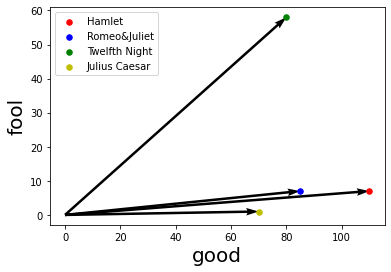

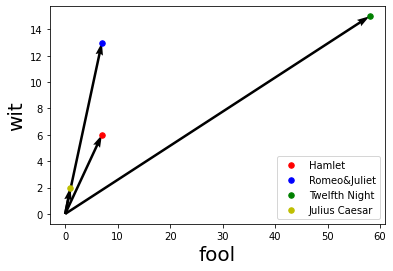

In [56]:
# put the plots into the notebook webpage
%matplotlib inline  

import matplotlib.pyplot as plt

def plot_dimensions(first_dim, second_dim, term_doc_cols):
    # create a list of starting points for arrows representing the vectors
    X = np.zeros(len(title_list))
    Y = np.zeros(len(title_list))

    # create the list of endpoints for the vector arrows
    U = term_doc_cols[:, first_dim]
    V = term_doc_cols[:, second_dim]
    
    # create a new figure
    plt.figure()
    
    # draw the arrows for the vectors
    plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1)
    
    # define some colours for markers for each document
    c = ['r', 'b', 'g', 'y']
    for i in range(len(title_list)):
        # plot the points in U, V and c as dots in the 2D graph
        plt.scatter(U[i], V[i], color=c[i], label=title_list[i], s=30)

    plt.legend()
    plt.xlabel(word_list[first_dim], fontsize = 20)
    plt.ylabel(word_list[second_dim], fontsize = 20)

    plt.show()
                         
plot_dimensions(1, 2, term_doc_cols)
plot_dimensions(2,3,term_doc_cols)

Now, we can use cosine similarity to calculate the similarity between two documents by their word counts for all words, given by ```term_doc_matrix```. Take Hamlet and Romeo&Juliet as an example. Sklearn also provides a function that implements cosine similarity between numpy arrays. When you pass the cosine_similarity function a list of vectors, it returns a matrix of similarities between all pairs of vectors in the list.

In [57]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(term_doc_matrix)

# use Pandas DataFrame again to get a nice matrix formatting:
cos_sim_df = pd.DataFrame(cos_sim, columns=title_list, index=title_list)
print("The cosine similarity matrix is:")
print(cos_sim_df)

# Access similarity for a single pair of documents:
print('The similarity between Hamlet and Romeo&Juliet is {}'.format(cos_sim[0][1]))

The cosine similarity matrix is:
                 Hamlet  Romeo&Juliet  Twelfth Night  Julius Caesar
Hamlet         1.000000      0.918428       0.908763       0.912049
Romeo&Juliet   0.918428      1.000000       0.899899       0.894511
Twelfth Night  0.908763      0.899899       1.000000       0.881946
Julius Caesar  0.912049      0.894511       0.881946       1.000000
The similarity between Hamlet and Romeo&Juliet is 0.9184280657904061


TODO: Without using the sklearn function, use numpy functions to calculate the cosine similarity between Hamlet and Romeo & Juliet from the values in ```term_doc_matrix```. Assign the result to a variable ```sim```.

$$similarity<v_1, v_2> = \frac{v_1 \cdot v_2}{|| v_1 || \cdot || v_2 ||}$$

Hints: 
   * You can calculate the dot product between two 1-D numpy arrays (vectors) using ```np.dot()``` and ```np.sqrt()```. 
   * The double bars mean vector length, for example $|| x || = \sqrt{\sum_{i=1}^D x^2}$ is the length of a vector $x$ with $D$ dimensions.
   * You will need the numpy functions ```np.sqrt()``` and ```np.sum()``` to compute the lengths.


In [58]:
# First, we get the vector representation of each book from the word_count_list.
book1 = term_doc_matrix[0, :]
book2 = term_doc_matrix[1, :]

In [61]:
### WRITE YOUR OWN CODE HERE
sim = (np.dot(book1, book2)) / (np.sqrt(np.dot(book1, book1)) * np.sqrt(np.dot(book2, book2)))

In [62]:
print('The similarity between Hamlet and Romeo&Juliet is {}'.format(sim))

The similarity between Hamlet and Romeo&Juliet is 0.918428065790406


## 2.TF-IDF


Using the word counts computed in the last part, we can calculate TF-IDF values for each term.  

There are several variants of TF-IDF that modify the basic equations to handle zero counts and frequent terms in different ways. Here, we will use this formula:

$$ tf(t,d) = count(t,d)$$
$$ idf(t) = 1+ ln\frac{N+1}{df(t+1)}$$

___Be aware that we use a different formula to the textbook.___ Compared to the textbook, the IDF score for terms that occur in all documents will be 1 rather than 0 so they are still weighted by their term frequency. Further explanations of the differences is given in: https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

Let's go step-by-step to compute the TF-IDF values.

Reminder: ```term_document_matrix``` should be an array where rows correspond to documents and columns to terms.

TODO: Complete the function below to compute document frequencies for a single term in a term-document matrix.

In [63]:
term_doc_matrix

array([[1, 1, 0, ..., 1, 1, 0],
       [1, 1, 4, ..., 1, 0, 2],
       [1, 1, 0, ..., 1, 0, 0],
       [1, 1, 0, ..., 1, 0, 0]])

In [122]:
# compute DF for a single term in the matrix
def document_frequency(term_doc_matrix, term_index):
    ### WRITE YOUR OWN CODE HERE
    term_df = pd.DataFrame(term_doc_matrix, columns=features, index=title_list).iloc[:,[term_index]]
    return np.count_nonzero(term_df) / term_df.shape[0]

print(document_frequency(term_doc_matrix, 34))    

0.25


TODO: Complete the function below to compute inverse document frequency from document frequency.

In [130]:
def inverse_document_frequency(df):
    ### WRITE YOUR OWN CODE HERE
    # we use different formula from the book/slides to keep results the same as sklearn's implementation
    return 1 + np.log((len(term_doc_matrix[:,1]) + 1) / (df + 1))

print(inverse_document_frequency(document_frequency(term_doc_matrix, 34)))

2.386294361119891


TODO: Complete the function below to compute term frequency for a single term in a given document.

In [131]:
def term_frequency(word_count, doc_index, term_index):
    ### WRITE YOUR OWN CODE HERE
    doc = word_count[doc_index]
    num_terms = doc[term_index]
    return num_terms / len(word_count[doc_index])

term_frequency(term_doc_matrix, 2, 539)

0.00011708230886313078

Now we can run the code below to compute a TF-IDF matrix.

In [133]:
tfidf_matrix = np.zeros((len(title_list), len(book_vocab)))
    
# iterate over terms in the vocabulary and compute TF-IDF
for t in book_vocab:  
    t_index = book_vocab[t]
    
    df = document_frequency(term_doc_matrix, t_index)  # df for this term

    for d in range(len(title_list)):  # iterate over documents in the list
        tf = term_frequency(term_doc_matrix, d, t_index)  
        idf = inverse_document_frequency(df)
        tfidf_matrix[d, t_index] = tf * idf

# normalize each document's tf-idf vector by its length (norm)
for d in range(len(title_list)): 
    norm = np.sum(tfidf_matrix[d, :] ** 2)
    norm = np.sqrt(norm)
    tfidf_matrix[d, :] = tfidf_matrix[d, :] / norm

# Select the columns for the words in word_list so we can print their values
def print_selected_words(title_list, word_list, matrix):
    cols = np.zeros((len(title_list), len(word_list)))
    for i, word in enumerate(word_list):
        cols[:, i] = matrix[:, book_vocab[word]]
    cols_df = pd.DataFrame(cols, index=title_list, columns=word_list)
    print(cols_df)
    
    return cols
    
print_selected_words(title_list, word_list, tfidf_matrix)

                 battle      good      fool       wit
Hamlet         0.000000  0.038867  0.002473  0.002120
Romeo&Juliet   0.000000  0.039761  0.003274  0.006081
Twelfth Night  0.000000  0.041844  0.030337  0.007846
Julius Caesar  0.005866  0.036637  0.000523  0.001047


array([[0.        , 0.03886726, 0.00247337, 0.00212003],
       [0.        , 0.03976096, 0.00327443, 0.00608109],
       [0.        , 0.04184379, 0.03033675, 0.00784571],
       [0.00586586, 0.03663737, 0.00052339, 0.00104678]])

```sklearn``` also provides powerful functions for us to calculate the TF-IDF values for a set of documents. We can use the count of words in ```term_doc_matrix``` as input.

In [114]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

# The class below transforms the sparse term-document matrix into TF-IDF values:
tfidf_transformer = TfidfTransformer()
tfidf_spmatrix = tfidf_transformer.fit_transform(term_doc_matrix)
tfidf_matrix = tfidf_spmatrix.toarray()

print_selected_words(title_list, word_list, tfidf_matrix)

                 battle      good      fool       wit
Hamlet         0.000000  0.037334  0.002376  0.002036
Romeo&Juliet   0.000000  0.037716  0.003106  0.005768
Twelfth Night  0.000000  0.040132  0.029096  0.007525
Julius Caesar  0.008567  0.034772  0.000497  0.000993


array([[0.        , 0.03733405, 0.0023758 , 0.0020364 ],
       [0.        , 0.03771612, 0.00310603, 0.00576835],
       [0.        , 0.04013238, 0.02909598, 0.00752482],
       [0.00856725, 0.03477246, 0.00049675, 0.0009935 ]])

Or we can calculate it directly from the text contained in ```book_list```:

In [134]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_spmatrix = tfidf_vectorizer.fit_transform(book_list)
vocab = tfidf_vectorizer.vocabulary_
tfidf_matrix = tfidf_spmatrix.toarray()

tfidf_doc_cols = print_selected_words(title_list, word_list, tfidf_matrix)

                 battle      good      fool       wit
Hamlet         0.000000  0.037334  0.002376  0.002036
Romeo&Juliet   0.000000  0.037716  0.003106  0.005768
Twelfth Night  0.000000  0.040132  0.029096  0.007525
Julius Caesar  0.008567  0.034772  0.000497  0.000993


We can display these books by their tf-idf vectors on a 2-D panel.  Run the code below to display the vector by taking 'good' as x-axis and 'fool' as y-axis. 

TODO: Compare this plot with the previous plot made using the term-document matrix. What are the similarities and diffierences?

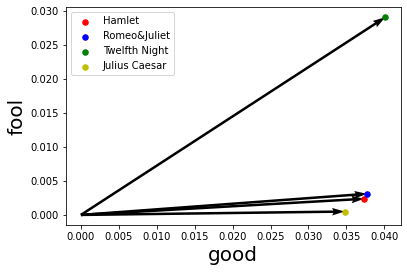

In [135]:
plot_dimensions(1, 2, tfidf_doc_cols)
# the overall shape is still familiar, twelfe night is still very much set apart 
# from the rest, but the rest of them are much more similar to each other in 
# terms of vector length and angle than before

We can also calculate similarities between the TF-IDF document vectors shown above. 

TODO: Use the ```tfidf_matrix``` that we've already got to calculate the cosine similarity between Hamlet and Romeo & Juliet. How do the values compare to the similarities computed using the original term-document matrix?

In [142]:
from sklearn.metrics.pairwise import cosine_similarity as sk_cos_sim

### WRITE YOUR OWN CODE HERE
book1 = tfidf_matrix[0, :]
book2 = tfidf_matrix[1, :]
cos_sim = (np.dot(book1, book2)) / (np.sqrt(np.dot(book1, book1)) * np.sqrt(np.dot(book2, book2)))

# use Pandas DataFrame again to get a nice matrix formatting:
# why is this here, its useless in this context
"""
cos_sim_df = pd.DataFrame(cos_sim, columns=title_list, index=title_list)
print("The cosine similarity matrix is:")
print(cos_sim_df)
"""

cos_sim_sk = sk_cos_sim(book1, book2)
print("Calculated cosine sim:",cos_sim)
print("Sklearn cos sim:",cos_sim_sk)
# the new cosine sim calculated from the tfidf matrix is noticeably different to the 
# one computed from the original term-document matrix with a decrease in similarity

The cosine similarity matrix is:
                Hamlet  Romeo&Juliet
Hmalet        0.816118      0.816118
Romeo&Juliet  0.816118      0.816118
0.8161183307638112
[[1.         0.81611833]
 [0.81611833 1.        ]]


## 3. Word2Vec

The previous section produce a term-document matrix and a TF-IDF matrix. As vector representations of a term, we can take the corresponding columns from these matrices. An alternative to these vector representations, which captures a lot more semantic information, is to use a word2vec word embedding. In this section, we will see how to obtain word2vec embeddings for the terms in our vocabulary.

We can import the Word2Vec model from ```gensim``` and apply it to our input as shown in the next cell. If we are dealing with a very large dataset, it's not convenient to load all the data into memory. Therefore, the Word2Vec function takes a LineSentence object as its input, which streams the data from disk as required by the algorithm. The code below creates a LineSentence object, then trains the skipgram model on the input text. 

Have a look at the documentation in https://radimrehurek.com/gensim/models/word2vec.html to find out what the other parameters do. 

In [143]:
import logging
import os
from gensim.models import word2vec

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

sentences = word2vec.LineSentence('shakespeare_sentences.txt')
model = word2vec.Word2Vec(sentences, sg=1, min_count=1, window=3, size=100)

2021-02-28 23:20:53,921 : INFO : collecting all words and their counts
2021-02-28 23:20:53,923 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-02-28 23:20:53,964 : INFO : PROGRESS: at sentence #10000, processed 62463 words, keeping 12074 word types
2021-02-28 23:20:54,005 : INFO : PROGRESS: at sentence #20000, processed 135687 words, keeping 20300 word types
2021-02-28 23:20:54,046 : INFO : PROGRESS: at sentence #30000, processed 197193 words, keeping 26449 word types
2021-02-28 23:20:54,095 : INFO : PROGRESS: at sentence #40000, processed 270222 words, keeping 33525 word types
2021-02-28 23:20:54,142 : INFO : PROGRESS: at sentence #50000, processed 348445 words, keeping 39382 word types
2021-02-28 23:20:54,192 : INFO : PROGRESS: at sentence #60000, processed 419695 words, keeping 43773 word types
2021-02-28 23:20:54,237 : INFO : PROGRESS: at sentence #70000, processed 484381 words, keeping 48711 word types
2021-02-28 23:20:54,294 : INFO : PROGRESS: at s

Once the model is trained, we can access the embedding for a word as follows:

In [144]:
model.wv['horse']

array([-0.02069795,  0.0202434 , -0.37368366, -0.09545694,  0.2972228 ,
       -0.40875295,  0.22774641,  0.08556322, -0.12545848, -0.28131792,
        0.17488453, -0.33611235,  0.03989315, -0.05669863, -0.03092194,
        0.2505722 ,  0.27439982,  0.00424395,  0.26692027, -0.57521164,
        0.36067456, -0.54002845, -0.13063644, -0.16428328,  0.1858009 ,
        0.0415387 ,  0.33363444, -0.21818721,  0.39366266,  0.02051857,
        0.33008882, -0.04566618, -0.27033526, -0.10098337, -0.2033539 ,
       -0.01962271,  0.3370707 ,  0.41431907,  0.71782595,  0.28082582,
       -0.3938224 , -0.12266684,  0.10372351,  0.15963976,  0.16459826,
       -0.14058985, -0.1534843 ,  0.24130952, -0.13607524, -0.36148128,
        0.31370968, -0.01721956,  0.35330155,  0.5818333 ,  0.04568664,
        0.04782134,  0.14761761,  0.16572438,  0.08706145, -0.18570124,
       -0.01664038,  0.02260878,  0.11812358, -0.12069236,  0.24255462,
       -0.02181391,  0.24290286,  0.05230559,  0.39013714,  0.88

The Gensim Word2Vec implementation provides various convenient built-in functions. Firstly, to find top $n$ words which are the most similar to the target word:

In [145]:
most_similar_words = model.wv.similar_by_word('love', topn = 10)
for word in most_similar_words:
    print(word)

2021-02-28 23:26:22,577 : INFO : precomputing L2-norms of word weight vectors


('fear', 0.9140092134475708)
('hate', 0.8981427550315857)
('pity', 0.8962258696556091)
('praise', 0.8928511142730713)
('care', 0.8898102641105652)
('love,', 0.8893955945968628)
('doing', 0.8863915205001831)
('believe', 0.8838284015655518)
('name', 0.8828940987586975)
('desire', 0.8808187246322632)


What do you think the second value in the list above shows?

We can also use a built-in function to calculate similarity:

In [146]:
print(model.wv.similarity('Romeo', 'Juliet'))

0.89155227


TODO: Calculate the similarities between Hamlet and Macbeth.

In [147]:
### WRITE YOUR OWN CODE HERE
print(model.wv.similarity('Hamlet', 'Macbeth'))

0.96223664


We can use ```doesnt_match``` to pick one word that doesn't match with the set. 'Happy' is the only adjective in the set:

In [150]:
print(model.wv.doesnt_match(('Mercutio Juliet Hamlet Macbeth happy').split(' ')))

happy


/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


TODO: Find the word doesn't match with \['Hamlet', 'Claudius', 'Polonius', 'Romeo', 'horse'\]

In [149]:
### WRITE YOUR OWN CODE HERE
print(model.wv.doesnt_match(['Hamlet', 'Claudius', 'Polonius', 'Romeo', 'horse']))

horse


/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


The word embeddings here are trained on the Shakespeare book text. This is suitable for using with text from  Shakespeare plays, but for many other types of text, we can use a pretrained word2vec model that has previously been learned from a very large dataset. Large datasets typically lead to better embeddings.

Gensim lets us access such a model as in the cell below (this may take some time to download the model):

In [151]:
import gensim.downloader

glove_vectors = gensim.downloader.load('glove-twitter-50')

# show the vector for Hamlet:
print(glove_vectors.wv['horse'])

2021-02-28 23:33:45,422 : INFO : Creating /root/gensim-data


[==================================================] 100.0% 199.5/199.5MB downloaded


2021-02-28 23:34:23,434 : INFO : glove-twitter-50 downloaded
2021-02-28 23:34:23,438 : INFO : loading projection weights from /root/gensim-data/glove-twitter-50/glove-twitter-50.gz
2021-02-28 23:36:06,169 : INFO : loaded (1193514, 50) matrix from /root/gensim-data/glove-twitter-50/glove-twitter-50.gz


[-0.45415  -0.5559    0.3165   -0.73472   0.48329  -0.47131   0.58741
  0.23555   0.34305  -0.16473   0.071575  0.42511  -3.4352    0.18617
  0.50667   0.27521   0.18426  -0.63193   0.32526  -0.25414   0.026154
  0.37055   0.82475  -0.29531   0.18063   0.86241  -0.77509   0.288
  0.39302  -0.54777   0.5931    0.29372   0.21855  -0.45915   0.19027
  0.56614   0.22987  -0.099232 -0.39798  -0.69595  -0.38917  -0.35256
 -0.82363   0.51109   0.63193   1.0831    0.5867    0.86035   0.1656
  0.50838 ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


You can find a list of models here in the 'Pretrained Models' section: https://radimrehurek.com/gensim/models/word2vec.html. 

**OPTIONAL** TODO: Compute the similarity between 'love' and 'fear' with the GloVe Twitter 50-dimensional embeddings. How does this compare to our Word2Vec embeddings trained on Shakespeare plays?

In [152]:
### WRITE YOUR OWN CODE HERE
glove_vectors.wv.similarity('love', 'fear')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


0.58080983

In the following weeks, we will see how to use the word embeddings as input representations for a classifier or sequence labeller.